# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [137]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
display(data.head())
print('Число дубликатов:', data.duplicated().sum())
print()
data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15

In [138]:
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 100
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,"23,699.00","23,699.00","23,699.00","23,699.00","14,504.00","23,613.00","21,796.00","23,699.00","21,421.00","12,180.00","18,157.00","18,180.00","18,181.00","8,079.00","18,181.00","9,110.00","20,518.00"
mean,9.86,"6,541,548.77",60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,"28,793.67","14,191.28",0.61,490.80,0.77,517.98,180.89
std,5.68,"10,887,013.27",35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,"12,630.88","8,608.39",0.80,342.32,0.94,277.72,219.73
min,0.00,"12,190.00",12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,"3,400,000.00",40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,"18,585.00","9,238.00",0.00,288.00,0.00,294.00,45.00
50%,9.00,"4,650,000.00",52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,"26,726.00","13,098.50",0.00,455.00,1.00,502.00,95.00
75%,14.00,"6,800,000.00",69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,"37,273.00","16,293.00",1.00,612.00,1.00,729.00,232.00
max,50.00,"763,000,000.00",900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,"84,869.00","65,968.00",3.00,"3,190.00",3.00,"1,344.00","1,580.00"


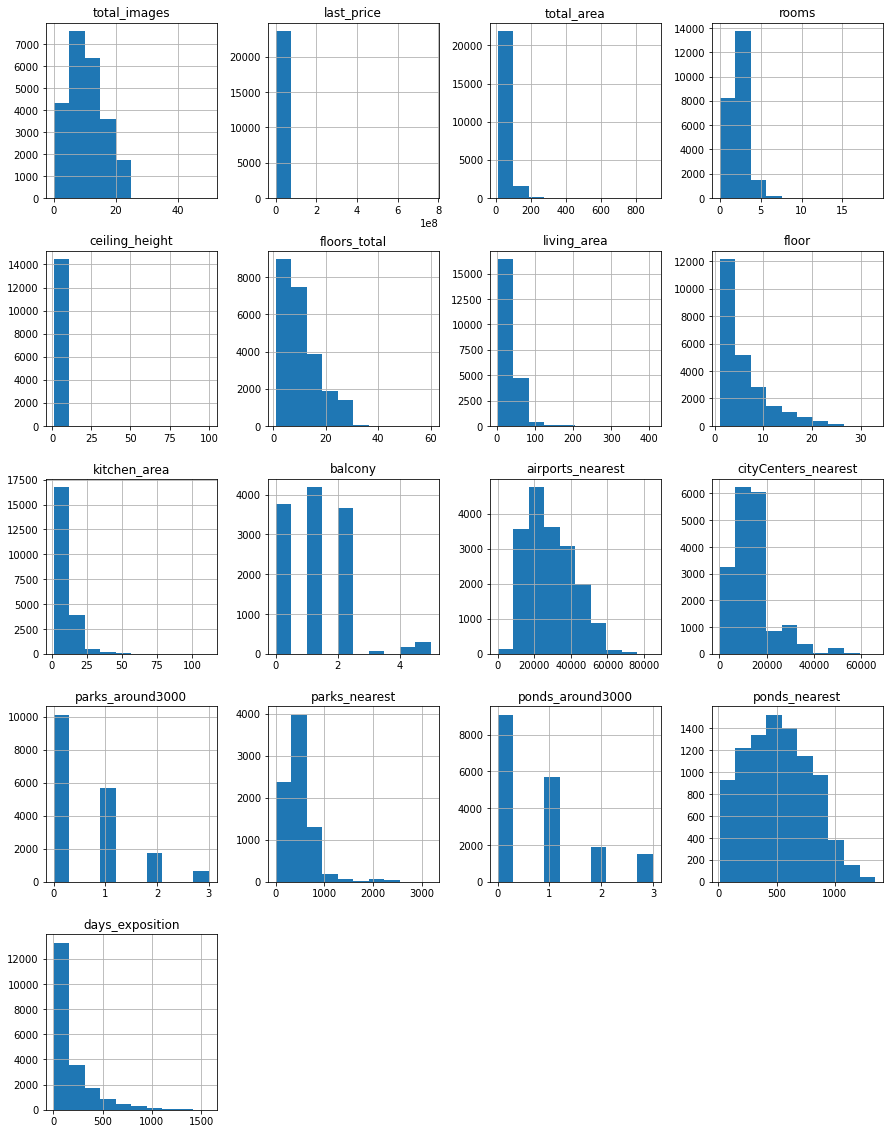

In [139]:
data.hist(figsize=(15, 20))
plt.show()

In [140]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Промежуточный вывод**:

Всего у нас 23699 записи. Для целого ряда столбцов есть пропущенные значения и некорректный тип данных.

### Предобработка данных

In [141]:
# Заполним пустые ячейки в высоте потолков медианным знаением
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
# Устранение аномальных значений в высоте потолков где указаны высота больше 15
def correct_hight(row):
  if row > 15:
    return (row / 10)
  else:
    return row
data['ceiling_height'] = data['ceiling_height'].apply(correct_hight)
# Перевод типа в инт с округлением высоты потолка до целого значения
data['ceiling_height'] = data['ceiling_height'].astype(np.int64)
# Удалим аномальные значение где высота ниже 2х метров и выше 6 метров 
data = data.drop(data.loc[(data['ceiling_height'] > 6) | (data['ceiling_height'] < 2)].index)
# Выведем количество размер потолков по высоте
print(data['ceiling_height'].value_counts())

2    21075
3     2529
4       77
5        7
6        1
Name: ceiling_height, dtype: int64


**Промежуточный вывод**:

Большое количество квартир с размеры потолков встречаются высотой 2х метров, встречаются и показатели выше это могут быть двух этажные квартиры, мы их не стали учитывать для анализа

In [142]:
# Удалим позици по название населённого пункта, и этажей всего
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)
# Заполним пустые значения в живой площади средним значением
living_ratio = data['living_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace =True)
# Заполним пустые значения в площади кухни средним значением
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

In [143]:
# Удаление позиции после заполнения, где сумма площади кухни и живой превышает общей
data = data.drop(data.loc[(data['kitchen_area'] + data['living_area']) > data['total_area']].index)

In [144]:
# Заполнение пропусков значением False
data['is_apartment'] = data['is_apartment'].fillna(value=False)
# Заполнение пустых значение по количеству балконов, и изменение типа
data['balcony'] = data['balcony'].fillna(value=0).astype(np.int32)
# Заполнение пустых значение по количеству Парков и Прудов в радиусе 3000, и изменение типа
data['parks_around3000'] = data['parks_around3000'].fillna(value=0).astype(np.int32)
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0).astype(np.int32)
# Изменение типов : Цена, Всего этажей в доме
data['last_price'] = data['last_price'].astype(np.int32)
data['floors_total'] = data['floors_total'].astype(np.int32)
# Замена формата времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')

In [145]:
# Замена аномальных значение в название населённого пункта
def replace_name(row):
  try:
    if 'поселок' in row:
      return row.replace('поселок', 'посёлок')
    elif 'посёлок при железнодорожной станции' in row:
      return row.replace('посёлок при железнодорожной станции', 'посёлок станции')
    elif 'городской посёлок' in row:
      return row.replace('городской посёлок', 'посёлок городского типа')     
    elif 'коттеджный посёлок' in row:
      return row.replace('коттеджный посёлок', 'посёлок')
    else:
      return row
  except:
    return row

data['locality_name'] = data['locality_name'].apply(replace_name)

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23436 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23436 non-null  int64         
 1   last_price            23436 non-null  int32         
 2   total_area            23436 non-null  float64       
 3   first_day_exposition  23436 non-null  datetime64[ns]
 4   rooms                 23436 non-null  int64         
 5   ceiling_height        23436 non-null  int64         
 6   floors_total          23436 non-null  int32         
 7   living_area           23436 non-null  float64       
 8   floor                 23436 non-null  int64         
 9   is_apartment          23436 non-null  bool          
 10  studio                23436 non-null  bool          
 11  open_plan             23436 non-null  bool          
 12  kitchen_area          23436 non-null  float64       
 13  balcony         

**Промежуточный вывод**:

- Заменили типы данных в колличественных позициях, на int для дальнейшего анализа.
- Заменили пустые значение в позициях высота потолков, живой площади,площадь кухни,apartment, балкон, парк(пруды) в радиусе 3000
- Решили вопрос по анаманальным значениям с названием населенных пунктов
- Удаление пустых значений для более корректного анализа
- Позиции где возможно брали расстояние из онлайн карт мы не стали заполнять ни какими данными, так же и день публикации на сайте
-------------------------------------------------------
- В колонках с количеством парков и водоемов в радиусе 3 км, а также с количеством балконов, отсутствие значений может быть связано с отсутствие наличия парков, водоемов и балконов.
- В колонке is_apartment если квартира не была апартаментами могли ничего и не указывать.
- В остальных колонках не заполнили значение это может быть человеческий или технический фактор.

### Посчитайте и добавьте в таблицу новые столбцы

In [147]:
# Добавляем столбец цена за м²
data['price_sm'] = data['last_price'] / data['total_area']
data['price_sm']

0       120,370.37
1        82,920.79
2        92,785.71
3       408,176.10
4       100,000.00
           ...    
23694    72,490.85
23695    52,542.37
23696    44,091.71
23697   149,511.40
23698    41,795.67
Name: price_sm, Length: 23436, dtype: float64

In [148]:
# Добавление столбцов с днями, месяцами, годами публикации
data['weekday_public'] = data['first_day_exposition'].dt.weekday
data['month_public'] = data['first_day_exposition'].dt.month
data['year_public'] = data['first_day_exposition'].dt.year

In [149]:
# Добавление столбца с типом этажа квартиры
def type_floors(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor > 1 and floor == floors_total:
        return 'последний'
    else:
        return 'другой'
data['type_floors'] = data.apply(type_floors, axis =1)
data['type_floors'].value_counts()

другой       17238
последний     3307
первый        2891
Name: type_floors, dtype: int64

In [150]:
# Добавление столбца расстояние в км до центра
def to_km(row):
  try:
    return round(row / 1000)
  except:
    return row
data['cityCentr_km'] = data['cityCenters_nearest'].apply(to_km)

### Проведите исследовательский анализ данных

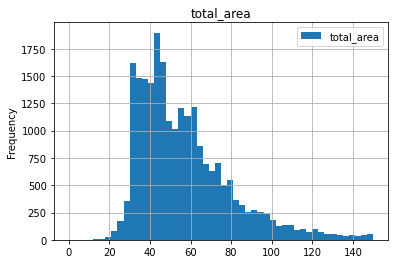

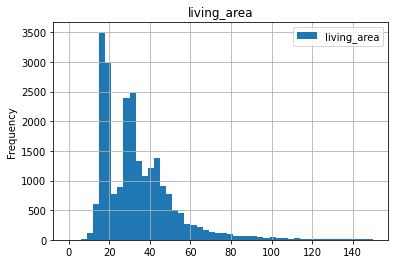

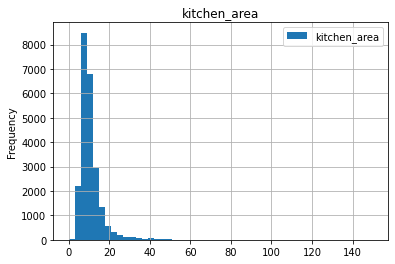

In [151]:
# Выявление количество кваритр по категорим : общая площадь, жилая площадь, площадь кухни
rows = ['total_area', 'living_area', 'kitchen_area']

for row in data[rows]:
  data.plot(kind='hist', y=row, title=row, bins=50,grid=True, range=(0, 150))

По выведенным данным мы видим, количество объявлений квартир
- По общей площади продаются около 50м²
- По живой площади около 18м²
- По площади кухни 10м²

<AxesSubplot:>

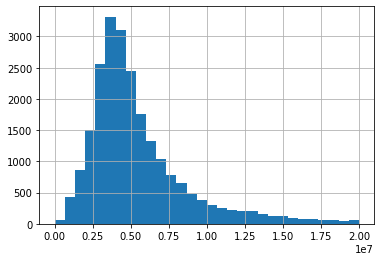

In [152]:
# Количество объявлений по частоте цены продажи
pd.Series(data['last_price']).hist(bins =30, range = (0, 20_000_000))

В основном стоимость квартир - порядка 5 миллионов. Больше 20 миллионов вариантов мало и они выглядят очень странно и некоторые - на порядок дороже.

<AxesSubplot:>

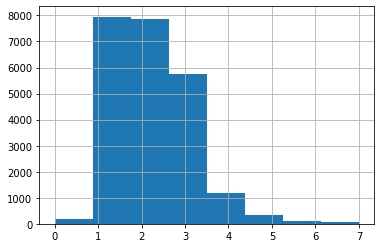

In [153]:
# Количество квартир по количество комнат
pd.Series(data['rooms']).hist(bins =8, range = (0, 7))

В основном квартиры состоят из 1, 2 и 3 комнат. Есть небольшая доля 4-комнатных квартир.

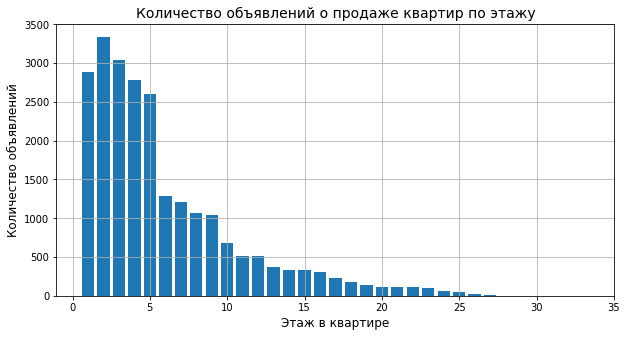

In [154]:
# Количество квартир по этажу
floor_count = data['floor'].value_counts()
fig = plt.figure(figsize = (10, 5))
plt.bar(floor_count.index.astype(int), floor_count)
 
plt.title(label = "Количество объявлений о продаже квартир по этажу", fontsize = 14)
plt.ylabel("Количество объявлений",  fontsize = 12)
plt.xlabel( "Этаж в квартире", size = 12)
plt.grid()
plt.show()

Частота объявление по кличеству объявлений по этажам, здесь мы видим что большенство обявление составлют квартиры до 5 этажа, чуть больше от 5 до 10 

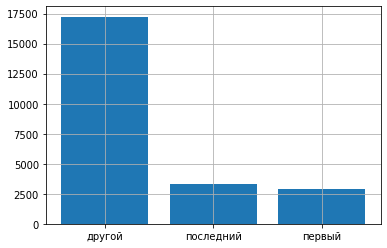

In [155]:
# Типы этажей по количеству объявлений
type_floor_count = data['type_floors'].value_counts()
plt.bar(type_floor_count.index, type_floor_count.values)
plt.grid()
plt.show()

Чаще продают квартиры между первым и последним

<AxesSubplot:>

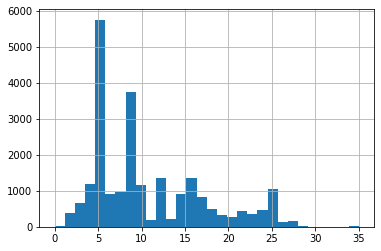

In [156]:
# Количество объявлений по этажам в доме всего в доме
pd.Series(data['floors_total']).hist(bins =30, range = (0,35))

Здесь мы видим что больше всего продают квартиры где в доме 5 этаже, дальше идут объявление где дома имеют 9 этажей

<AxesSubplot:>

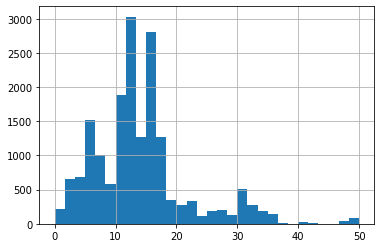

In [157]:
# Количество объявлении квартир по удаленности от центра
pd.Series(data['cityCentr_km']).hist(bins =30, range = (0,50))

Больше продают квартиры в среднем от 10 до 18 км от центра города

<AxesSubplot:ylabel='Frequency'>

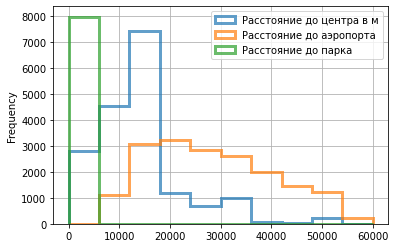

In [158]:
# Таблица с расстояниями от центра, аэропорта и парков
areas = ['cityCenters_nearest', 'airports_nearest', 'parks_nearest']
data.plot(
    kind='hist', 
    y=areas, 
    alpha=0.7, 
    histtype='step', 
    linewidth=3,
    grid=True, 
    range=(0, 60_000),
    label = ['Расстояние до центра в м', 'Расстояние до аэропорта', 'Расстояние до парка']
)

По нашим данным мы видим :

- Большинство квартир продают где рассторяние до центра составляет от 10_000м до 18_000м
- По расстоянию от аэропортов, идет чем дальше расстоянии тем меньше объявлений начиная от 11_000м
- Большое количество парков находится близко

<AxesSubplot:ylabel='Frequency'>

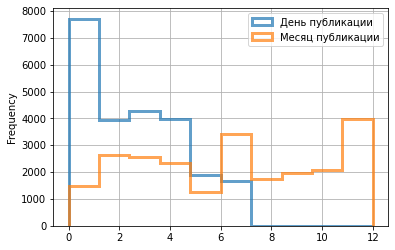

In [159]:
# День и месяц публикации
areas = ['weekday_public', 'month_public']
data.plot(
    kind='hist', 
    y=areas, 
    alpha=0.7, 
    histtype='step', 
    linewidth=3,
    grid=True, 
    range=(0, 12),
    label = ['День публикации', 'Месяц публикации']
)

День публикации обычно приходится на Пн, а по месяцам люди выставляют на продажу квартиры в середине года и в конце

Значение маедианы: 95
Значение среднее: 180


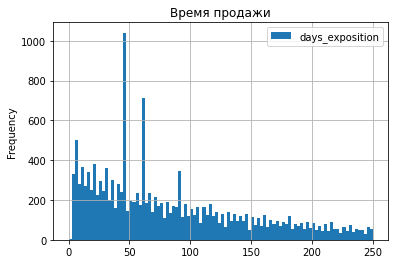

count    20277
mean       180
std        219
min          1
25%         45
50%         95
75%        232
max       1580
Name: days_exposition, dtype: int64


In [160]:
# Время продажи квартиры
print('Значение маедианы:', data['days_exposition'].median().astype(int))
print('Значение среднее:', data['days_exposition'].mean().astype(int))
data.plot(
    kind='hist', 
    y='days_exposition', 
    title='Время продажи',
    grid=True, 
    range=(0, 250), 
    bins=100)
plt.show()
print(data['days_exposition'].describe().astype(int))

- Медианное время продажи - 95 дней.

- Среднее время продажи - 180 дней

- В основном квартиры продаются за срок в 100 дней

- Быстрой продажей можно назвать срок в 45 дней и меньше. Долгой продажей - 232 дня
-------------------------------------------------

- На данном графике мы видим выбивающиеся знаачения так как мы ограничили вывод графика range(0, 250), тем самы на графигке мы можем увидеть, что большое количсетво снятых объявлений было через 45 и 60 дней, если мы уберем ограничение то это уже будет не так заметно. (ограничение помогло более детально рассмотреть график, так как попадаются небольшое количество значений где обьявление о продаже висело годами)

(0.0, 300.0)

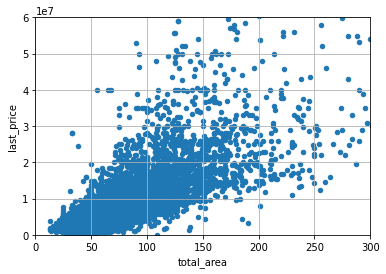

In [161]:
# Взаимосвязь общей площади кв и ценой
data.plot(
    x='total_area',
    y='last_price',
    kind='scatter',
    grid=True)
plt.ylim(0,60_000_000)
plt.xlim(0,300)

Взаимосвязь есть чем больше площадь квартиры тем больше цена

(0.0, 300.0)

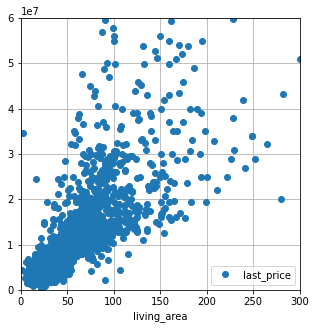

In [162]:
# Взаимосвязь жилой площади и ценой
(
data
    .pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.ylim(0,60_000_000)
plt.xlim(0,300)

Взаимосвязь есть, чем больше живая площаль тем больше стоимость

(0.0, 60.0)

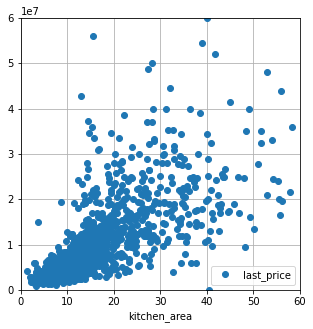

In [163]:
# Взаимосвязь площади кухни и ценой квартиры
(
data
    .pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.ylim(0,60_000_000)
plt.xlim(0,60)

Взаимосвязь есть, чем больше площадь кухни тем больше стоимость

Text(0.5, 0, 'Количество комнат')

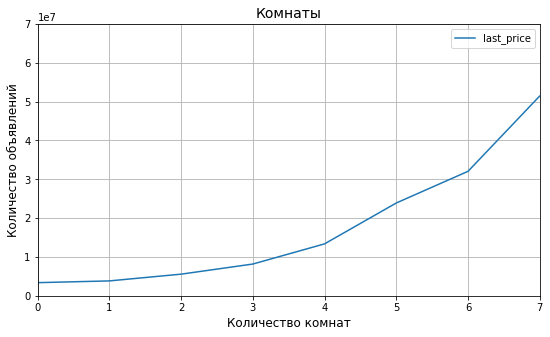

In [164]:
# Взаимосвязь Колиество комнат и ценой квартир
(
data
    .pivot_table(index='rooms', values='last_price')
    .plot(grid=True,figsize=(9, 5))
)
plt.ylim(0,70_000_000)
plt.xlim(0,7)
plt.title(label = "Комнаты", fontsize = 14)
plt.ylabel("Количество объявлений",  fontsize = 12)
plt.xlabel( "Количество комнат", size = 12)

Взаимосвязь есть, чем больше комнат тем больше стоимость

Text(0, 0.5, 'Количество объявлений')

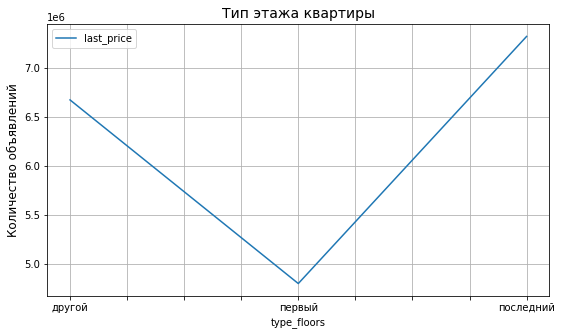

In [165]:
# Взаимосвщяь типов этажей квартиры и ценой
(
data
    .pivot_table(index='type_floors', values='last_price')
    .plot(grid=True,figsize=(9, 5))
)
plt.title(label = "Тип этажа квартиры", fontsize = 14)
plt.ylabel("Количество объявлений",  fontsize = 12)

Взаимосвязь с типом квартиры и стоимости, что первый эатж дешевле продают чем другой и последний

Text(0.5, 0, 'Год')

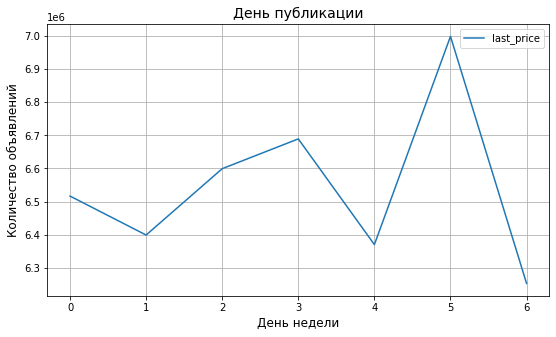

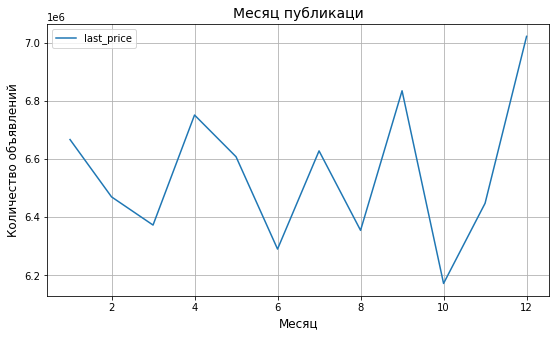

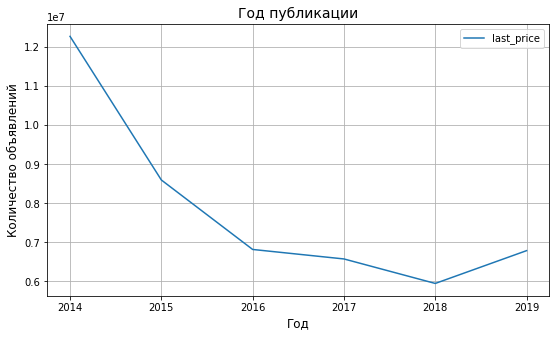

In [166]:
#день публикации объявления(0 - понедельник, 1 - вторник и т.д.)
data.pivot_table(index='weekday_public', values='last_price').plot(grid=True, figsize=(9, 5))
plt.title(label = "День публикации", fontsize = 14)
plt.ylabel("Количество объявлений",  fontsize = 12)
plt.xlabel( "День недели", size = 12)
#месяц публикации объявления
data.pivot_table(index='month_public', values='last_price').plot(grid=True, figsize=(9, 5))
plt.title(label = "Месяц публикаци", fontsize = 14)
plt.ylabel("Количество объявлений",  fontsize = 12)
plt.xlabel( "Месяц", size = 12)
#год публикации объявления
data.pivot_table(index='year_public', values='last_price').plot(grid=True, figsize=(9, 5))
plt.title(label = "Год публикации", fontsize = 14)
plt.ylabel("Количество объявлений",  fontsize = 12)
plt.xlabel( "Год", size = 12)

Взаимосзявь между ценой и временем публикации мы видим

- В субботу выставляют больше квартир с большой ценой, возможно это связанно с тем что первый выходной, или с тем что люди думают об большой продаже всю неделю
- Выставляют на продажу чаще к концу года, либо боятся роста цен в следующем году , что бы успеть купить новую квартиру или хотят кординально, что то изменить в следующем
- Чаще продавали квартиры в 2014 году

In [167]:
# Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
top_ten = data['locality_name'].value_counts().head(10)
mean_price = ( 
    data 
    .query('locality_name in (@top_ten.index)')
    .groupby('locality_name')['price_sm'].mean().astype(np.int32)
)
print(mean_price.sort_values(ascending=False))
print()
print(f'В Санкт-Петербурге самая высокая стоимость одного квадратного метра: {mean_price.max()}')
print(f'В Выборге самая низкая стоимость одного квадратного метра: {mean_price.min()}')

locality_name
Санкт-Петербург      114702
Пушкин               103125
деревня Кудрово       92524
посёлок Парголово     90135
посёлок Мурино        85475
посёлок Шушары        78546
Колпино               75480
Гатчина               68625
Всеволожск            68572
Выборг                58154
Name: price_sm, dtype: int32

В Санкт-Петербурге самая высокая стоимость одного квадратного метра: 114702
В Выборге самая низкая стоимость одного квадратного метра: 58154


Здесь мы видим самую высокую стоимость м² находится в Санкт-Петербурге, а населенном пункте Выборге стоимсоть за м² самая низкая. Обясняется это тем что чем ближе к Санкт-Петербургу, тем самым и к количеству парков, прудов и др строительных объектов стоимость повышается

In [168]:
# Средняя цена каждого километра
def km_price(row):
  try:
    return int(row['last_price']/row['cityCentr_km'])
  except:
    return None

data['km_price'] = data.apply(km_price, axis =1)

<AxesSubplot:ylabel='Frequency'>

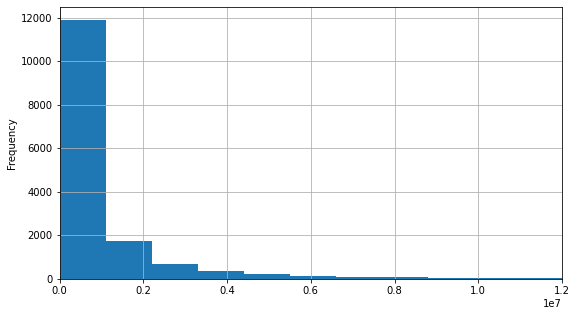

In [169]:
# Квартиры в Санкт-Петербурге и средняя цена каждого километра
data_spb = data.loc[data['locality_name'] == 'Санкт-Петербург']
data_spb['km_price'].plot(kind ='hist',xlim = (0, 12_000_000), bins = 300, grid = True,figsize=(9, 5))

Здесь мы видим средняя стоимость км в Санкт-Петербурге выше когда расстояние меньше, чем дальше от центра, объявлении все меньше и меньше

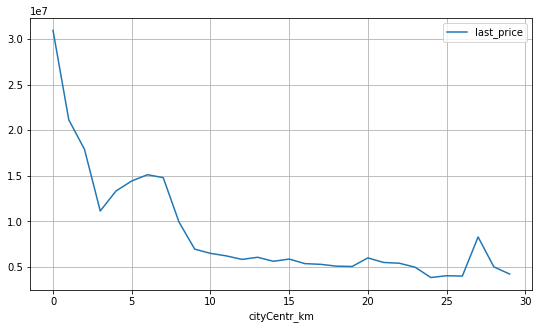

In [170]:
# Количество объектов по цене продажи объявлении и расстоянию от центра
(
data_spb
    .pivot_table(index='cityCentr_km', values='last_price')
    .plot(grid=True, figsize=(9, 5))
)
plt.show()

In [171]:
s = data.pivot_table(index='cityCentr_km', values='last_price')
s.head()

,last_price
cityCentr_km,
0.00,"30,927,928.00"
1.00,"21,143,335.44"
2.00,"17,892,114.27"
3.00,"11,146,705.37"
4.00,"13,339,077.83"


Здесь мы видим, что чем ближе мы к центру тем больше количество объявлении

### Общий вывод

**Срок продажи квартиры**

Чаще всего квартиру продают за 95 дней. Если меньше 45 дней, то это быстро, если дольше 230 дней - это долго.
Есть большое число квартир, проданных всего за несколько дней после публикации.
Также есть варианты, которые продавались несколько десятков месяцев.

**Факторы, влияющие на стоимость**

На стоимость больше влияет площадь квартиры, нежели число комнат. Т.е. могут быть дорогие квартиры с малым числом комнат.
Первый этаж значительно дешевле остальных вариантов. Также стоимость квартиры на последнем этаже ниже, чем на остальных, кроме первого.

**Стоимость квадратного метра в топ-10 населённых пунктов**

Дороже всего квадратный метр в Санкт-Петербурге - 115199.09
Дешевле всего квадратный метр в Выборге - 58309.2

**Факторы, влияющие на стоимость в центре Санкт-Петербурга**

В центре города практически нет разницы, насколько квартира удалена от условного центра города.